# Baseline CRNN Model + CTC loss function to crack Captcha OCR problem

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import json

# make sure we use tensorflow 2.0
import tensorflow as tf
print(tf.__version__)

# import padding library
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import our model, different layers and activation function
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
DATASET_ZIP_PATH="/content/drive/MyDrive/cap/data/catpcha_images.zip"
import zipfile
with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("captcha_project")

In [ ]:
!ls

captcha_project  drive	sample_data


In [ ]:
# finding where we are so we dont need to type absolute path everytime
# current_directory_path = pathlib.Path(".").absolute()
current_directory_path = pathlib.Path("./captcha_project")
current_directory_path

PosixPath('captcha_project')

In [ ]:
# path to our directory images

# our raw folders
RAW_FOLDER = os.path.join(current_directory_path, "raw")

In [ ]:
print(RAW_FOLDER)

captcha_project/raw


In [ ]:
# checking if GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    # RIP Training time
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Reading images and organise folders

In [ ]:
# checking the total alphabet characters of the whole dataset
raw_data_path = pathlib.Path(RAW_FOLDER)
char_list= set()
dict_file_label={}
for item in raw_data_path.glob('*'):
    label = os.path.basename(os.path.splitext(item)[0])
    dict_file_label[str(item)]=label
    char_list.update(set((label)))
char_list=sorted(char_list)

print("Total number of characters : {}".format(len(char_list)))

Total number of characters : 32


In [ ]:
# show all possible labels characters
"".join(char_list)

'23456789ABCDEFGHJKLMNPQRSTUVWXYZ'

In [ ]:
# find the maximum label length
label_lens= []
for label in dict_file_label.values():
    label_lens.append(len(label))
max_label_len = max(label_lens)

In [ ]:
# Only because this dataset is CAPTCHA so the length of all labels are 4.
max_label_len

4

In [ ]:
# convert the words to array of indexs based on the char_list
def encode_to_labels(txt):
    # encoding each output word into digits of indexes
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print("No found in char_list :", char)

    return dig_lst

In [ ]:
# testing our encode function (text to number)
encode_to_labels("2345ABCDE")

[0, 1, 2, 3, 8, 9, 10, 11, 12]

In [ ]:
# all possible image paths for training
all_image_paths = list(dict_file_label.keys())

In [ ]:
all_image_paths[:5]

['captcha_project/raw/E99S.png',
 'captcha_project/raw/R6GF.png',
 'captcha_project/raw/M3JS.png',
 'captcha_project/raw/6GUQ.png',
 'captcha_project/raw/25MZ.png']

In [ ]:
# find all widths and heights of images (this is useful if our dataset images got different sizes)
widths = []
heights = []
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    (height, width, _) = img.shape
    heights.append(height)
    widths.append(width)

In [ ]:
min_height = min(heights)
max_height = max(heights)
min_width = min(widths)
max_width = max(widths)

In [ ]:
# this information is useful for making decision for padding and resizing
(min_height, max_height, min_width, max_width)

(24, 24, 72, 72)

In [ ]:
# being a good Data Scientist, we need to have train set and test set
from sklearn.model_selection import train_test_split
test_size = 0.3
train_image_paths, test_image_paths = train_test_split(all_image_paths, test_size=test_size, random_state=42)
val_image_paths, test_image_paths = train_test_split(test_image_paths, test_size=0.5, random_state=42)

## Preprocessing

In [ ]:
# Constants (we choose this number as we later discover that the output of our CNN is (1,9,512) from out input)
TIME_STEPS = 9

In [ ]:
# TO DO LIST: BUILD THE PIPELINE FOR THE IMAGES, definitely this is super basic pipeline and can be improved

# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

i=0
for train_img_path in train_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(train_img_path), cv2.COLOR_BGR2GRAY)

    # in this dataset, we don't need to do any resize at all here.

    # add channel dimension
    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img/255.

    label = dict_file_label[train_img_path]

    orig_txt.append(label)
    train_label_length.append(len(label))

    # our time steps for valid input
    train_input_length.append(TIME_STEPS)
    training_img.append(img)

    # convert words to digits based on charlist
    training_txt.append(encode_to_labels(label))
    i+=1
    if (i%500 == 0):
        print ("has processed trained {} files".format(i))

has processed trained 500 files
has processed trained 1000 files
has processed trained 1500 files
has processed trained 2000 files
has processed trained 2500 files
has processed trained 3000 files
has processed trained 3500 files
has processed trained 4000 files
has processed trained 4500 files
has processed trained 5000 files
has processed trained 5500 files
has processed trained 6000 files
has processed trained 6500 files


In [ ]:
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

i=0

for val_img_path in val_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(val_img_path), cv2.COLOR_BGR2GRAY)

    # in this dataset, we don't need to do any resize at all here.

    # add channel dimension
    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img/255.

    label = dict_file_label[val_img_path]

    valid_orig_txt.append(label)
    valid_label_length.append(len(label))

    # our time steps for valid input
    valid_input_length.append(TIME_STEPS)
    valid_img.append(img)

    # convert words to digits based on charlist
    valid_txt.append(encode_to_labels(label))
    i+=1
    if (i%500 == 0):
        print ("has processed val {} files".format(i))

has processed val 500 files
has processed val 1000 files


In [ ]:
#lists for validation dataset
test_img = []
test_txt = []
test_input_length = []
test_label_length = []
test_orig_txt = []

i=0

for test_img_path in test_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2GRAY)

    # in this dataset, we don't need to do any resize at all here.

    # add channel dimension
    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img/255.

    label = dict_file_label[test_img_path]

    test_orig_txt.append(label)
    test_label_length.append(len(label))

    # our time steps for valid input
    test_input_length.append(TIME_STEPS)
    test_img.append(img)

    # convert words to digits based on charlist
    test_txt.append(encode_to_labels(label))
    i+=1
    if (i%500 == 0):
        print ("has processed test {} files".format(i))

has processed test 500 files
has processed test 1000 files


In [ ]:
# this is the most controversial part when our max_label_len should be set different or slightly smaller than TIME_STEPS
# but let stick to the conventional/normal way: we should to be the same with our TIME_STEPS
max_label_len = TIME_STEPS

In [ ]:
# pad each output label to maximum text length, remember we did that so that we keep training with rnn consistent?
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)
test_padded_txt = pad_sequences(test_txt, maxlen=max_label_len, padding='post', value = 0)

## Model Building

In [ ]:
# OUR FULL MODEL OF CRNN AND LSTM

# input with shape of height=32 and width=128
inputs = Input(shape=(24,72,1))

# convolution layer with kernel size (3,3)  #(24,72,64)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(12,36,64)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

#(12,36,128)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(6,18,128)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

#(6,18,256)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

# poolig layer with kernel size (2,2) to make the height/2  #(3,9,256)
pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

batch_norm_3 = BatchNormalization()(pool_3)

#(3,9,256)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(batch_norm_3)

# Batch normalization layer #(3,9,256)
batch_norm_5 = BatchNormalization()(conv_4)

#(3,9,512)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)

# poolig layer with kernel size (2,2) to make the height/2 #(1,9,512)
pool_6 = MaxPool2D(pool_size=(3, 1))(batch_norm_6)

# # to remove the first dimension of one: (1,9,512) -> (9,512)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_6)

# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time

act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 72, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 72, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 36, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 18, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 18, 256)        2951

In [ ]:

# define the label input shape for ctc
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath='checkpoint_weights.hdf5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=15,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 24, 72, 1)]          0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 24, 72, 64)           640       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 12, 36, 64)           0         ['conv2d_5[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 12, 36, 128)          73856     ['max_pooling2d_4[0][0]'

In [ ]:
# ready our training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

# ready our valid data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

# ready our test data
test_img = np.array(test_img)
test_input_length = np.array(test_input_length)
test_label_length = np.array(test_label_length)

## Model Training

In [ ]:
# choose batchsize and epochs

batch_size = 32
epochs = 50

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length],
          y=np.zeros(len(training_img)),
          batch_size=batch_size,
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callbacks_list)

Epoch 1/50
217/218 [============================>.] - ETA: 0s - loss: 5.0093
Epoch 1: val_loss improved from inf to 48.97802, saving model to checkpoint_weights.hdf5
218/218 [==============================] - 20s 49ms/step - loss: 4.9925 - val_loss: 48.9780 - lr: 0.0010
Epoch 2/50
217/218 [============================>.] - ETA: 0s - loss: 0.0916
Epoch 2: val_loss improved from 48.97802 to 7.43793, saving model to checkpoint_weights.hdf5
218/218 [==============================] - 9s 39ms/step - loss: 0.0914 - val_loss: 7.4379 - lr: 0.0010
Epoch 3/50
216/218 [============================>.] - ETA: 0s - loss: 0.0352
Epoch 3: val_loss improved from 7.43793 to 4.98651, saving model to checkpoint_weights.hdf5
218/218 [==============================] - 7s 32ms/step - loss: 0.0355 - val_loss: 4.9865 - lr: 0.0010
Epoch 4/50
217/218 [============================>.] - ETA: 0s - loss: 0.0531
Epoch 4: val_loss did not improve from 4.98651
218/218 [==============================] - 9s 40ms/step - lo

In [ ]:
# save our model
model.save('lastest_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Decode and Prediction

In [ ]:
# load the saved best model weights
act_model.load_weights('lastest_model.h5')

In [ ]:
# predict outputs on validation images
NO_PREDICTS = 200
OFFSET=0
prediction = act_model.predict(test_img)
#prediction = act_model.predict(valid_img)

47/47 [==============================] - 1s 15ms/step


In [ ]:
test_img.shape

(1494, 24, 72, 1)

In [ ]:
# NO_PREDICTS image results
# 9 timesteps
# 32 chars + 1 blank
prediction.shape

(1494, 9, 33)

In [ ]:
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

# see the results
all_predictions =[]
i = 0
for x in out:
    print("original_text  = ", test_orig_txt[i+OFFSET])
    print("predicted text = ", end = '')
    pred = ""
    for p in x:
        if int(p) != -1:
            pred += char_list[int(p)]
    print(pred)
    all_predictions.append(pred)
    i+=1

original_text  =  TXSJ
predicted text = TXSJ
original_text  =  GYS4
predicted text = GYS4
original_text  =  DTVE
predicted text = DTVE
original_text  =  8XPX
predicted text = 8XPX
original_text  =  56KR
predicted text = 56KR
original_text  =  2FEW
predicted text = 2FEW
original_text  =  EVP6
predicted text = EVP6
original_text  =  HUCR
predicted text = HUCR
original_text  =  5TKV
predicted text = 5TKV
original_text  =  66QM
predicted text = 66QM
original_text  =  BJXZ
predicted text = BJXZ
original_text  =  MARK
predicted text = MARK
original_text  =  AGPE
predicted text = AGPE
original_text  =  MVQ4
predicted text = MVQ4
original_text  =  6D3C
predicted text = 6D3C
original_text  =  NHH8
predicted text = NHH8
original_text  =  G4NA
predicted text = G4NA
original_text  =  FSWA
predicted text = FSWA
original_text  =  GYMR
predicted text = GYMR
original_text  =  E99W
predicted text = E99W
original_text  =  FNXR
predicted text = FNXR
original_text  =  P2GJ
predicted text = P2GJ
original_t

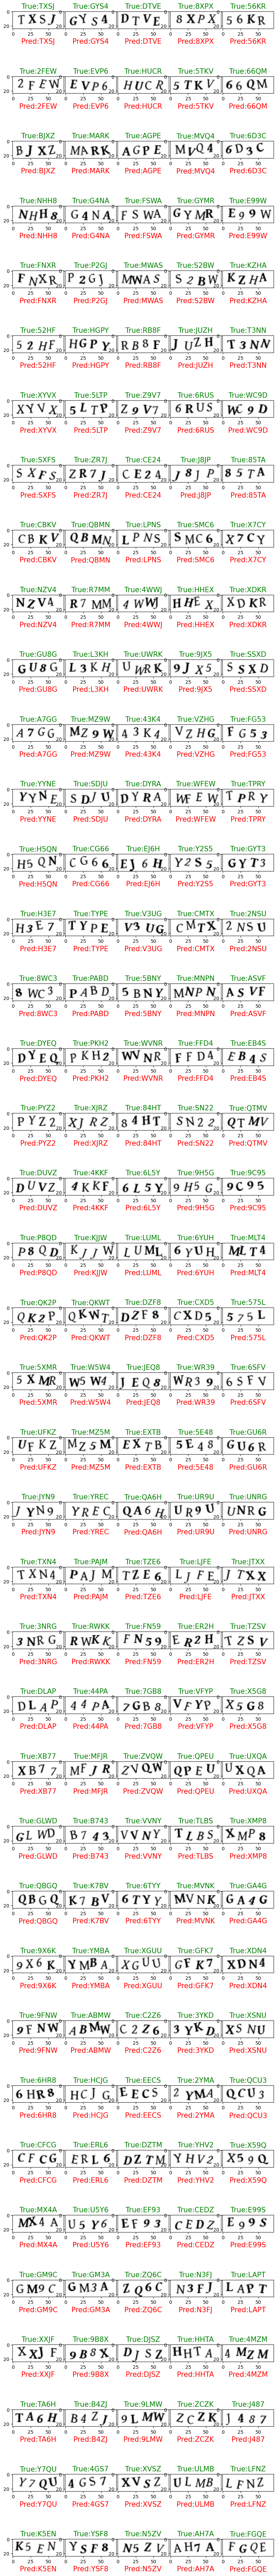

In [ ]:
# WRITE TO PRINT OUT THE IMAGES IN NICE 2D ARRAY PLOT WITH ORIGINAL TEXT AND PREDICTED TEXT
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10,100))
col=0
row=1
gs1 = gridspec.GridSpec(NO_PREDICTS//5, 5)
gs1.update(wspace=0.025, hspace=0.025)
for n in range(NO_PREDICTS):
    plt.subplot(gs1[n])
    plt.title("True:"+test_orig_txt[n+OFFSET], fontsize=15, color="green")
    plt.imshow(test_img[n][:,:,0], cmap="gray")
    plt.xlabel("Pred:"+all_predictions[n+OFFSET], fontsize=15, color="red")


## Evaluation using CER, WER and SER

- CER (Character Error Rate)
- WER (Word Error Rate)
- SER (Sequence Error Rate)

In [ ]:
import string
import unicodedata
import editdistance

def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)

In [ ]:
evaluate = ocr_metrics(predicts=all_predictions,
                                  ground_truth=test_orig_txt,
                                  norm_accentuation=False,
                                  norm_punctuation=False)

e_corpus = "\n".join([
    "Metrics:",
    "Character Error Rate: {}".format(evaluate[0]),
    "Word Error Rate:      {}".format(evaluate[1]),
    "Sequence Error Rate:  {}".format(evaluate[2]),
])

This is a easy dataset so I got perfect score for absolutely the test set! Not even a challenge for CRNN power!

In [ ]:
print(e_corpus)

Metrics:
Character Error Rate: 0.0
Word Error Rate:      0.0
Sequence Error Rate:  0.0
